In [1]:
import os
import scipy.misc
import numpy as np
import json

from model_steer import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 108, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", None, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", None, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
FLAGS = flags.FLAGS

In [ ]:
def main(_):
  pp.pprint(flags.FLAGS.__flags)
  
  # expand user name and environment variables
  FLAGS.data_dir = expand_path(FLAGS.data_dir)
  FLAGS.out_dir = expand_path(FLAGS.out_dir)
  FLAGS.out_name = expand_path(FLAGS.out_name)
  FLAGS.checkpoint_dir = expand_path(FLAGS.checkpoint_dir)
  FLAGS.sample_dir = expand_path(FLAGS.sample_dir)

  print('FLAGS.dataset:', FLAGS.dataset)  
  print('FLAGS.output_height', FLAGS.output_height)  
  print('flags.train', FLAGS.train)

  if FLAGS.output_height is None: FLAGS.output_height = FLAGS.input_height
  if FLAGS.input_width is None: FLAGS.input_width = FLAGS.input_height
  if FLAGS.output_width is None: FLAGS.output_width = FLAGS.output_height

  # output folders
  if FLAGS.out_name == "":
      FLAGS.out_name = '{} - {} - {}'.format(timestamp(), FLAGS.data_dir.split('/')[-1], FLAGS.dataset) # penultimate folder of path
      if FLAGS.train:
        FLAGS.out_name += ' - x{}.z{}.{}.y{}.b{}'.format(FLAGS.input_width, FLAGS.z_dim, FLAGS.z_dist, FLAGS.output_width, FLAGS.batch_size)

  FLAGS.out_dir = os.path.join(FLAGS.out_dir, FLAGS.out_name)
  FLAGS.checkpoint_dir = os.path.join(FLAGS.out_dir, FLAGS.checkpoint_dir)
  FLAGS.sample_dir = os.path.join(FLAGS.out_dir, FLAGS.sample_dir)

  if not os.path.exists(FLAGS.checkpoint_dir): os.makedirs(FLAGS.checkpoint_dir)
  if not os.path.exists(FLAGS.sample_dir): os.makedirs(FLAGS.sample_dir)

  with open(os.path.join(FLAGS.out_dir, 'FLAGS.json'), 'w') as f:
    flags_dict = {k:FLAGS[k].value for k in FLAGS}
    json.dump(flags_dict, f, indent=4, sort_keys=True, ensure_ascii=False)
  

  #gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
  run_config = tf.ConfigProto()
  run_config.gpu_options.allow_growth=True

  with tf.Session(config=run_config) as sess:
    if FLAGS.dataset == 'mnist':
      dcgan = DCGAN(
          sess,
          input_width=FLAGS.input_width,
          input_height=FLAGS.input_height,
          output_width=FLAGS.output_width,
          output_height=FLAGS.output_height,
          batch_size=FLAGS.batch_size,
          sample_num=FLAGS.batch_size,
          y_dim=10,
          z_dim=FLAGS.z_dim,
          dataset_name=FLAGS.dataset,
          input_fname_pattern=FLAGS.input_fname_pattern,
          crop=FLAGS.crop,
          checkpoint_dir=FLAGS.checkpoint_dir,
          sample_dir=FLAGS.sample_dir,
          data_dir=FLAGS.data_dir,
          out_dir=FLAGS.out_dir,
          max_to_keep=FLAGS.max_to_keep)
    else:
      dcgan = DCGAN(
          sess,
          input_width=FLAGS.input_width,
          input_height=FLAGS.input_height,
          output_width=FLAGS.output_width,
          output_height=FLAGS.output_height,
          batch_size=FLAGS.batch_size,
          sample_num=FLAGS.batch_size,
          z_dim=FLAGS.z_dim,
          dataset_name=FLAGS.dataset,
          input_fname_pattern=FLAGS.input_fname_pattern,
          crop=FLAGS.crop,
          checkpoint_dir=FLAGS.checkpoint_dir,
          sample_dir=FLAGS.sample_dir,
          data_dir=FLAGS.data_dir,
          out_dir=FLAGS.out_dir,
          max_to_keep=FLAGS.max_to_keep)

    show_all_variables()

    if FLAGS.train:
      dcgan.train(FLAGS)
    else:
      load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
      if not load_success:
        raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)


    # to_json("./web/js/layers.js", [dcgan.h0_w, dcgan.h0_b, dcgan.g_bn0],
    #                 [dcgan.h1_w, dcgan.h1_b, dcgan.g_bn1],
    #                 [dcgan.h2_w, dcgan.h2_b, dcgan.g_bn2],
    #                 [dcgan.h3_w, dcgan.h3_b, dcgan.g_bn3],
    #                 [dcgan.h4_w, dcgan.h4_b, None])

    # Below is codes for visualization
      if FLAGS.export:
        export_dir = os.path.join(FLAGS.checkpoint_dir, 'export_b'+str(FLAGS.batch_size))
        dcgan.save(export_dir, load_counter, ckpt=True, frozen=False)

      if FLAGS.freeze:
        export_dir = os.path.join(FLAGS.checkpoint_dir, 'frozen_b'+str(FLAGS.batch_size))
        dcgan.save(export_dir, load_counter, ckpt=False, frozen=True)

      if FLAGS.visualize:
        OPTION = 1
        visualize(sess, dcgan, FLAGS, OPTION, FLAGS.sample_dir)

# if __name__ == '__main__':
#   tf.app.run()

In [ ]:
# tf.app.run(argv=['--dataset', 'mnist', '--input_height=28', '--output_height=28', '--train'])

loading mnist...


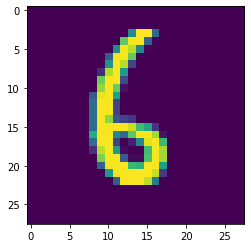

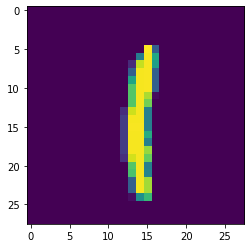

In [7]:
import matplotlib.pyplot as plt
print('loading mnist...')
data_dir = os.path.join('./data', 'mnist')

fd = open(os.path.join(data_dir,'train-images-idx3-ubyte'))
loaded = np.fromfile(file=fd,dtype=np.uint8)
trX = loaded[16:].reshape((60000,28,28,1)).astype(np.float)

# idx = np.random.choice(60000, 50000, replace=False)
idx = np.random.choice(60000, 1, replace=False)
for i in range(len(idx)):
    img_test_5px = np.zeros([28,28], dtype= 'float')
    img_test = trX[idx[i],:,:,0]
    offset_val = np.random.randint(1, 6)  
    coin = np.random.uniform(0, 1)
    if coin <= 0.5:
        offset_val = -offset_val            
    if(offset_val > 0):
        img_test_5px[:,offset_val:] = img_test[:,:-offset_val]
    else:
        img_test_5px[:,:28+offset_val] = img_test[:,-offset_val:]
    trX[idx[i],:,:,0] = img_test_5px
    plt.figure()
    plt.imshow(img_test_5px)

fd = open(os.path.join(data_dir,'train-labels-idx1-ubyte'))
loaded = np.fromfile(file=fd,dtype=np.uint8)
trY = loaded[8:].reshape((60000)).astype(np.float)

fd = open(os.path.join(data_dir,'t10k-images-idx3-ubyte'))
loaded = np.fromfile(file=fd,dtype=np.uint8)
teX = loaded[16:].reshape((10000,28,28,1)).astype(np.float)

# idx = np.random.choice(10000, 9000, replace=False)
idx = np.random.choice(10000, 1, replace=False)
for i in range(len(idx)):
    img_test_5px = np.zeros([28,28], dtype= 'float')
    img_test = teX[idx[i],:,:,0]
    offset_val = np.random.randint(0, 6)  
    coin = np.random.uniform(0, 1)
    if coin <= 0.5:
        offset_val = -offset_val            
    if(offset_val > 0):
        img_test_5px[:,offset_val:] = img_test[:,:-offset_val]
    else:
        img_test_5px[:,:28+offset_val] = img_test[:,-offset_val:]
    teX[idx[i],:,:,0] = img_test_5px
    plt.figure()
    plt.imshow(img_test_5px)


fd = open(os.path.join(data_dir,'t10k-labels-idx1-ubyte'))
loaded = np.fromfile(file=fd,dtype=np.uint8)
teY = loaded[8:].reshape((10000)).astype(np.float)

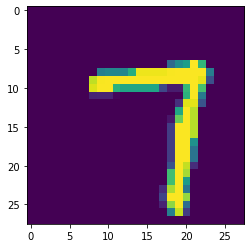

In [6]:
plt.imshow(img_test_5px)
